# First Order Local Uncertainty Analysis for Chemical Reaction Systems

This ipython notebook performs first order local uncertainty analysis for a chemical reaction system
using a RMG-generated model.  

In [1]:
from rmgpy.tools.uncertainty import Uncertainty
from rmgpy.tools.canteraModel import getRMGSpeciesFromUserSpecies
from rmgpy.species import Species
from IPython.display import display, Image
import os

Using Theano backend.


In [7]:
# Define the CHEMKIN and Dictionary file paths.  This is a reduced phenyldodecane (PDD) model.

# Must use annotated chemkin file
chemkinFile = '/home/rgillis/Code/RMG-Py/examples/rmg/DMSOxy/t58/chemkin/chem_annotated3.inp'
dictFile = '/home/rgillis/Code/RMG-Py/examples/rmg/DMSOxy/t58/chemkin/species_dictionary3.txt'

# Alternatively, unhighlight the following lines and comment out the lines above to use the minimal model,
# which will not take as long to process
# Make sure to also uncomment the specified lines two code blocks down which are related

# chemkinFile = 'data/minimal_model/chem_annotated.inp'
# dictFile = 'data/minimal_model/species_dictionary.txt'

Initialize the `Uncertainty` class object with the model.

In [8]:
uncertainty = Uncertainty(outputDirectory='uncertainty')
uncertainty.loadModel(chemkinFile, dictFile)

We can now perform stand-alone sensitivity analysis.

In [9]:
# Map the species to the objects within the Uncertainty class
DMS = Species().fromSMILES("CSC")
HOOH = Species().fromSMILES("OO")
OH = Species().fromSMILES("[OH]")
O2 = Species().fromSMILES("[O][O]")
N2 = Species().fromSMILES("N#N")
DMSO = Species().fromSMILES("CS(=O)C")
SO2 = Species().fromSMILES("O=S=O")

mapping = getRMGSpeciesFromUserSpecies([DMS,HOOH,OH,O2,N2,DMSO,SO2], uncertainty.speciesList)

initialMoleFractions = {mapping[N2]: 0.79494, mapping[O2]: 0.205, mapping[OH]: 0.000030, mapping[DMS]: 0.000015}
T = (298,'K')
P = (1,'bar')
terminationTime = (1, 'h')
sensitiveSpecies=[mapping[DMSO], mapping[SO2]]


# If you used the minimal model, uncomment the following lines and comment out the lines above 

# ethane = Species().fromSMILES('CC')
# C2H4 = Species().fromSMILES('C=C')
# Ar = Species().fromSMILES('[Ar]')
# mapping = getRMGSpeciesFromUserSpecies([ethane, C2H4, Ar], uncertainty.speciesList)

# # Define the reaction conditions
# initialMoleFractions = {mapping[ethane]: 1.0, mapping[Ar]:50.0}
# T = (1300,'K')
# P = (1,'atm')
# terminationTime = (5e-4, 's')
# sensitiveSpecies=[mapping[ethane], mapping[C2H4]]

# Perform the sensitivity analysis
uncertainty.sensitivityAnalysis(initialMoleFractions, sensitiveSpecies, T, P, terminationTime, sensitivityThreshold=1e-1, number=5, fileformat='.png')

DMSO(5): Reaction Sensitivities


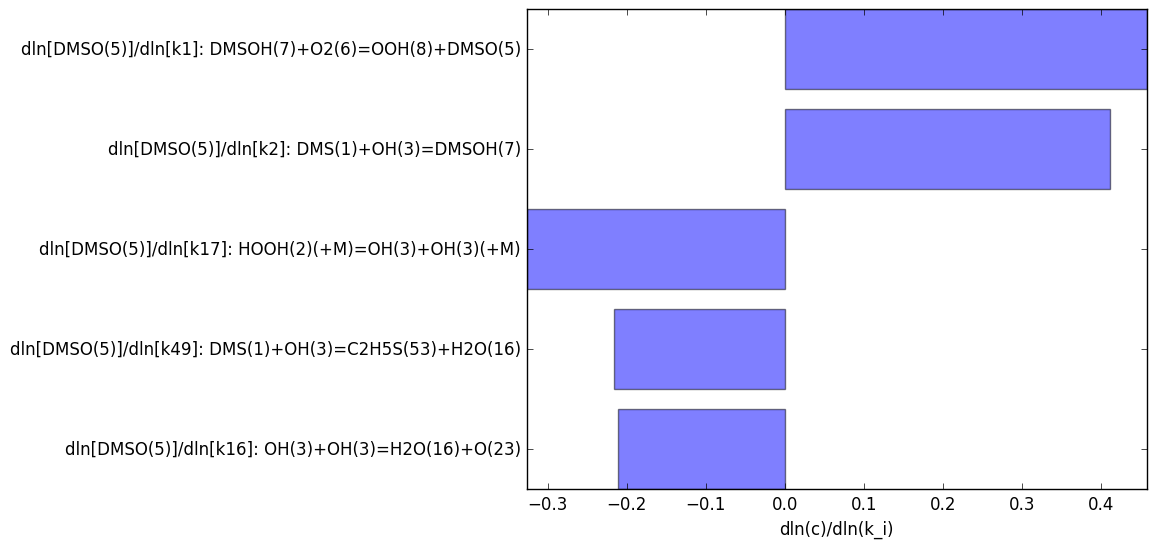

DMSO(5): Thermo Sensitivities


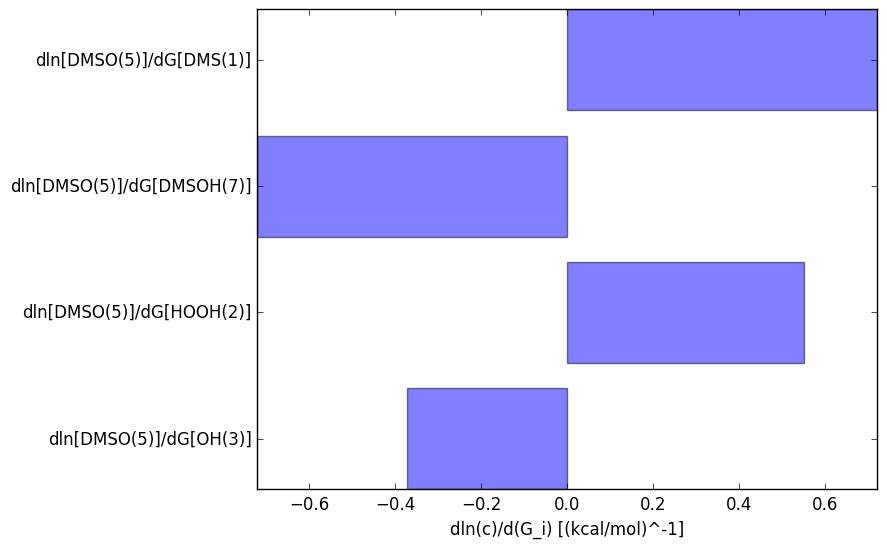

SO2(4): Reaction Sensitivities


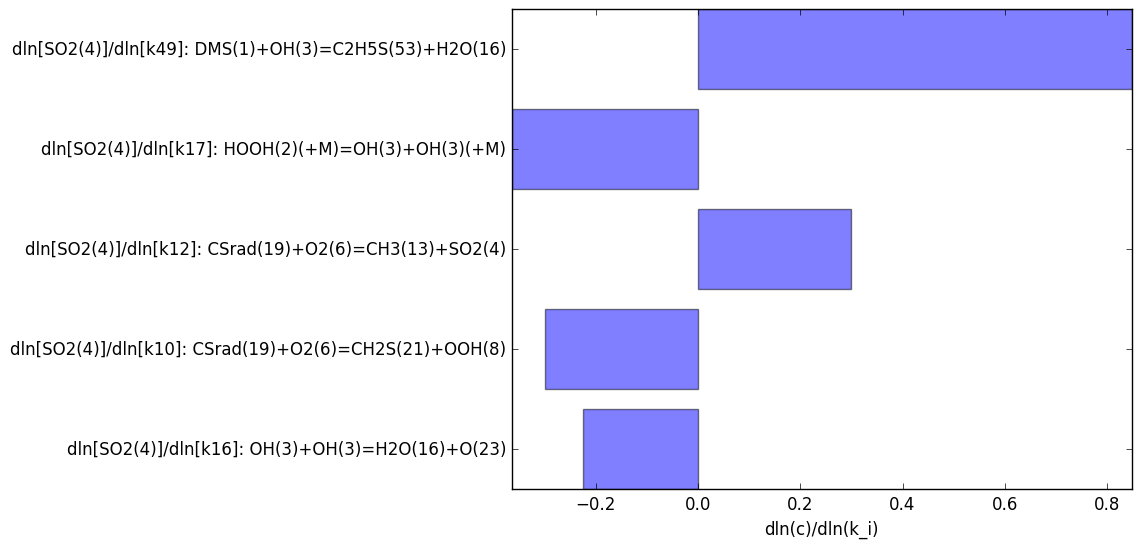

SO2(4): Thermo Sensitivities


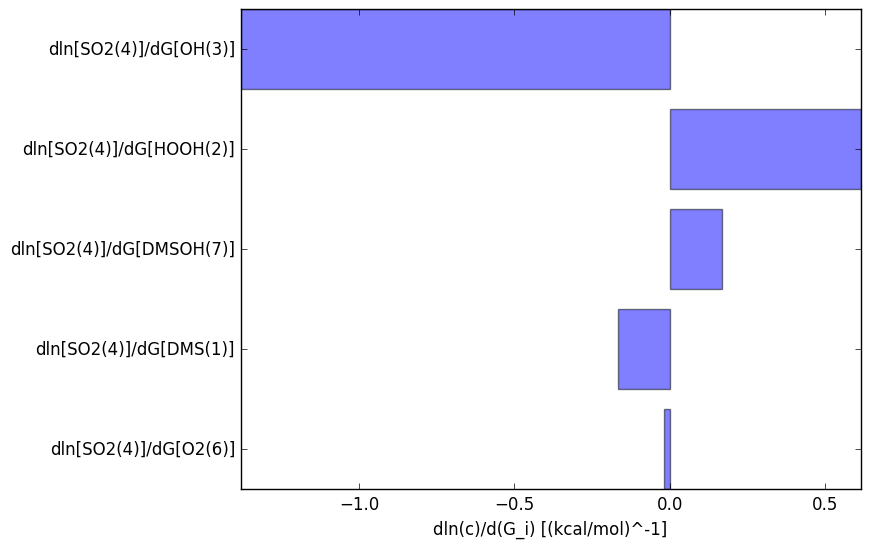

In [10]:
# Show the sensitivity plots
for species in sensitiveSpecies:
    print '{}: Reaction Sensitivities'.format(species)
    index = species.index
    display(Image(filename=os.path.join(uncertainty.outputDirectory,'solver','sensitivity_1_SPC_{}_reactions.png'.format(index))))
    
    print '{}: Thermo Sensitivities'.format(species)
    display(Image(filename=os.path.join(uncertainty.outputDirectory,'solver','sensitivity_1_SPC_{}_thermo.png'.format(index))))

If we want to run local uncertainty analysis, we must assign all the uncertainties using the `Uncertainty` class' `assignParameterUncertainties` function. `ThermoParameterUncertainty` and `KineticParameterUncertainty` classes may be customized and passed into this function if non-default constants for constructing the uncertainties are desired. This must be done after the parameter sources are properly extracted from the model.

## Thermo Uncertainty

Each species is assigned a uniform uncertainty distribution in free energy:

$G \in [G_{min},G_{max}]$

$dG = (G_{max} - G_{min})/2$

Several parameters are used to formulate $dG$.  These are $dG_{library}$, $dG_{QM}$, $dG_{GAV}$, and $dG_{group}$.
        
$dG =  \delta_{library} dG_{library} + \delta_{QM} dG_{QM} +
\delta_{GAV} dG_{GAV} +
\sum_{group} w_{group} dG_{group}$

where $\delta$ is a dirac delta function which equals one if the species thermochemistry parameter contains the particular source type and $w_{group}$ is the weight of the thermo group used to construct the  species thermochemistry in the group additivity method.

## Kinetics Uncertainty

Each reaction is assigned a uniform uncertainty distribution in the overall ln(k), or ln(A):

$d \ln (k) \in [\ln(k_{min}),\ln(k_{max})]$

$d\ln(k) = [\ln(k_{max})-\ln(k_{min})]/2$

The parameters used to formulate $d \ln(k)$ are $d\ln(k_{library})$, $d\ln(k_{training})$, $d\ln(k_{pdep})$, $d\ln(k_{family})$, $d\ln(k_{non-exact})$, and $d\ln(k_{rule})$.

For library, training, and pdep reactions, the kinetic uncertainty is assigned according to their uncertainty type.  For kinetics estimated using RMG's rate rules, the following formula is used to calculate the uncertainty:

$d \ln (k) = d\ln(k_{family}) + \log_{10}(N+1)*dln(k_{non-exact})+\sum_{rule} w_{rule} d \ln(k_{rule})$

where N is the total number of rate rules used and $w_{rule}$ is the weight of the rate rule used to estimate the kinetics. 

In [11]:
uncertainty.loadDatabase(kineticsFamilies='default')
uncertainty.extractSourcesFromModel()
uncertainty.assignParameterUncertainties()

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.6869,38.2195,39.253,40.4473,45.0357,50.6323,54.2027],'J/(mol*K)'), H298=(310.047,'kJ/mol'), S298=(162.808,'J/(mol*K)'), Cp0=(29.1007,'J/(mol*K)'), CpInf=(37.4151,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(CsJ2_singlet-CsH)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.6869,38.2195,39.253,40.4473,45.0357,50.6323,54.2027],'J/(mol*K)'), H298=(310.047,'kJ/mol'), S298=(162.808,'J/(mol*K)'), Cp0=(29.1007,'J/(mol*K)'), CpInf=(37.4151,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(CsJ2_singlet-CsH)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 1666.66666667 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.6869,38.2195,39.253,40.44

The first order local uncertainty, or variance $(d\ln c_i)^2$, for the concentration of species $i$ is defined as:

$(d\ln c_i)^2 = \sum_j \left(\frac{d\ln c_i}{d\ln k_j}d\ln k_j\right)^2 + \sum_k \left(\frac{d\ln c_i}{dG_k}dG_k\right)^2$

We have previously performed the sensitivity analysis.  Now we perform the local uncertainty analysis and apply the formula above using the parameter uncertainties and plot the results.  This first analysis considers the parameters to be independent.  In other words, even when multiple species thermochemistries depend on a single thermo group or multiple reaction rate coefficients depend on a particular rate rule, each value is considered independent of each other.  This typically results in a much larger uncertainty value than in reality due to cancellation error.

In [12]:
uncertainty.localAnalysis(sensitiveSpecies, correlated=False, number=5, fileformat='.png')

DMSO(5): Thermo Uncertainty Contributions


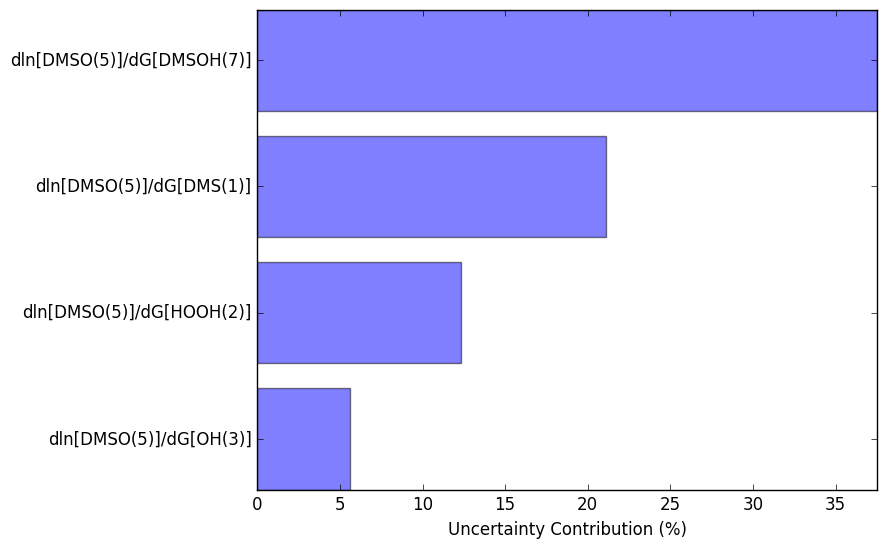

DMSO(5): Reaction Uncertainty Contributions


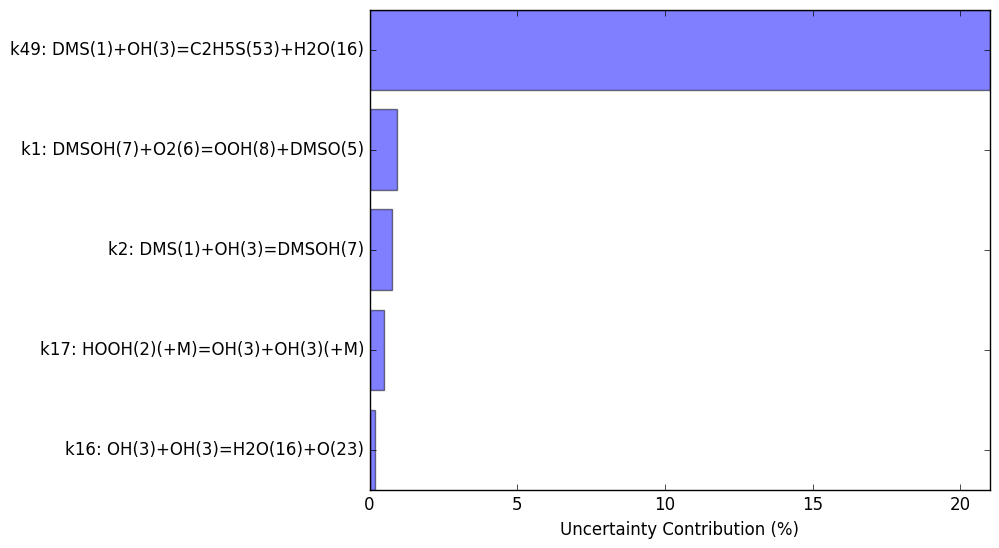

SO2(4): Thermo Uncertainty Contributions


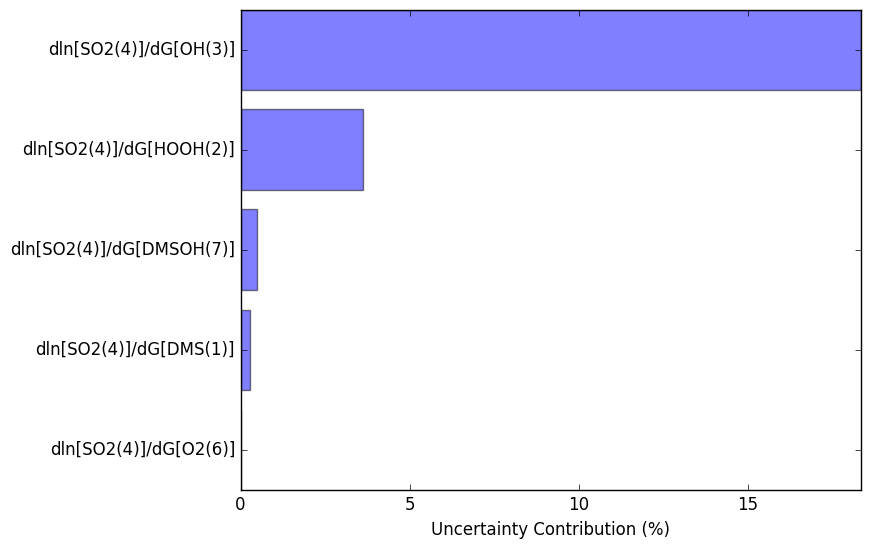

SO2(4): Reaction Uncertainty Contributions


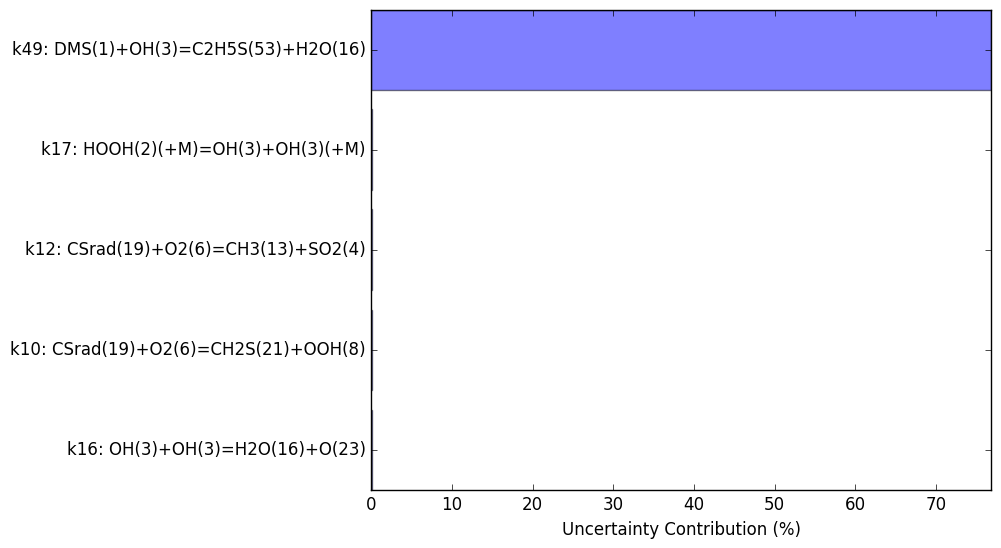

In [13]:
# Show the uncertainty plots
for species in sensitiveSpecies:
    print '{}: Thermo Uncertainty Contributions'.format(species)
    display(Image(filename=os.path.join(uncertainty.outputDirectory,'thermoLocalUncertainty_{}.png'.format(species.toChemkin()))))
    
    print '{}: Reaction Uncertainty Contributions'.format(species)
    display(Image(filename=os.path.join(uncertainty.outputDirectory,'kineticsLocalUncertainty_{}.png'.format(species.toChemkin()))))

## Correlated Uncertainty

A more accurate picture of the uncertainty in mechanism estimated using groups and rate rules requires accounting of the correlated errors resulting from using the same groups in multiple parameters.  This requires us to track the original sources: the groups and the rate rules, which constitute each parameter.  These errors may cancel in the final uncertainty calculation.  Note, however, that the error stemming from the estimation method itself do not cancel.  

For thermochemistry, the error terms described previously are $dG_{library}$, $dG_{QM}$, $dG_{GAV}$, and $dG_{group}$.  Of these, $dG_{GAV}$ is an uncorrelated independent residual error, whereas the other terms are correlated.   Noting this distinction, we can re-categorize and index these two types of parameters in terms of correlated sources $dG_{corr,y}$ and uncorrelated sources $dG_{res,z}$.

For kinetics, the error terms described perviously are $d\ln(k_{library})$, $d\ln(k_{training})$, $d\ln(k_{pdep})$, $d\ln(k_{family})$, $d\ln(k_{non-exact})$, and $d\ln(k_{rule})$.  Of these, $d\ln(k_{family})$, $d\ln(k_{non-exact})$ are uncorrelated independent error terms resulting from the method of estimation.  Again, we re-categorize the correlated versus non-correlated sources as $d\ln k_{corr,v}$ and $d\ln k_{res,w}$, respectively.  

The first order local uncertainty, or variance $(d\ln c_{corr,i})^2$, for the concentration of species $i$ becomes:


$(d\ln c_{corr,i})^2 = \sum_v \left(\frac{d\ln c_i}{d\ln k_{corr,v}}d\ln k_{corr,v}\right)^2 + \sum_w \left(\frac{d\ln c_i}{d\ln k_{res,w}}d\ln k_{res,w}\right)^2 + \sum_y \left(\frac{d\ln c_i}{dG_{corr,y}}dG_{corr,y}\right)^2 + \sum_z \left(\frac{d\ln c_i}{dG_{res,z}}dG_{res,z}\right)^2$

where the differential terms can be computed as:

$\frac{d\ln c_i}{d\ln k_{corr,v}} = \sum_j \frac{d\ln c_i}{d\ln k_j}\frac{d\ln k_j}{d\ln k_{corr,v}}$

$\frac{d\ln c_i}{d G_{corr,y}} = \sum_k \frac{d\ln c_i}{dG_k}\frac{dG_k}{dG_{corr,y}}$

In [14]:
uncertainty.assignParameterUncertainties(correlated=True)
uncertainty.localAnalysis(sensitiveSpecies, correlated=True, number=10, fileformat='.png')

DMSO(5): Thermo Uncertainty Contributions


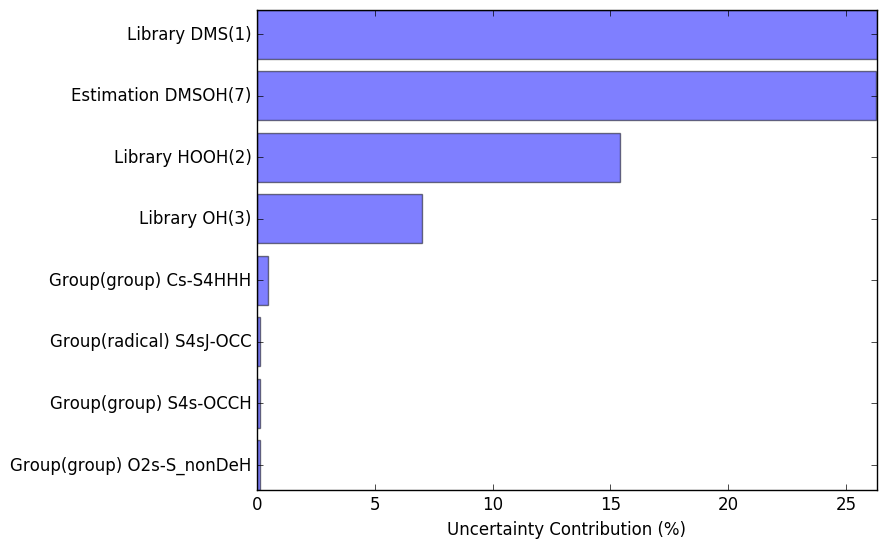

DMSO(5): Reaction Uncertainty Contributions


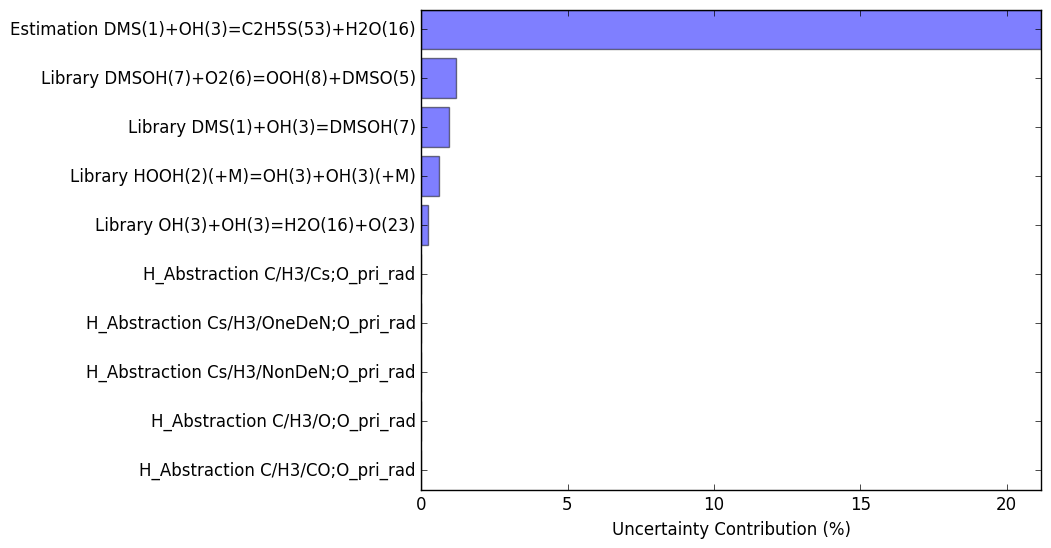

SO2(4): Thermo Uncertainty Contributions


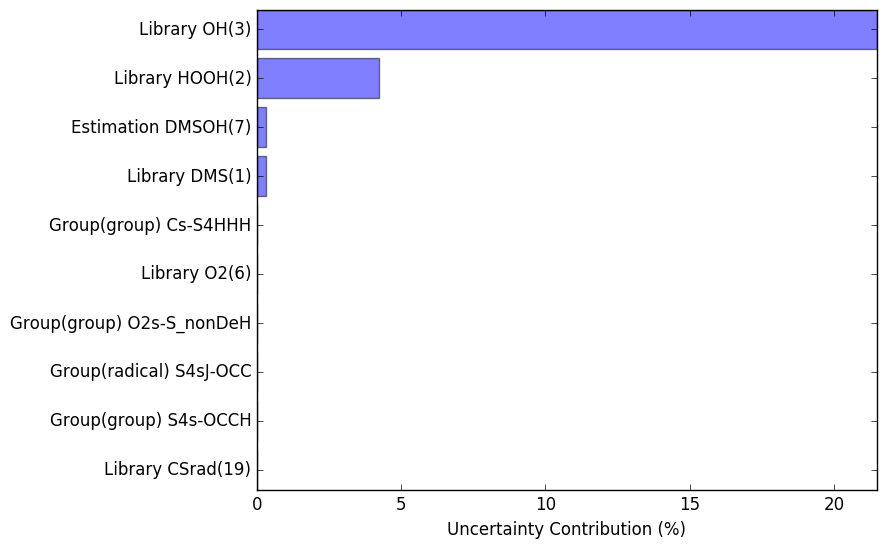

SO2(4): Reaction Uncertainty Contributions


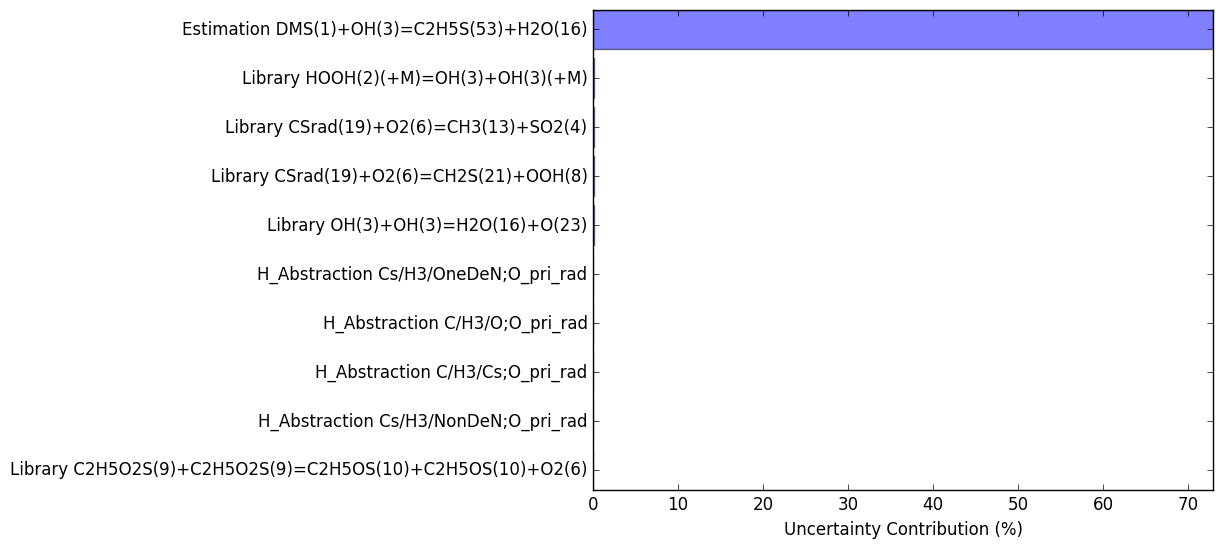

In [15]:
# Show the uncertainty plots
for species in sensitiveSpecies:
    print '{}: Thermo Uncertainty Contributions'.format(species)
    display(Image(filename=os.path.join(uncertainty.outputDirectory,'thermoLocalUncertainty_{}.png'.format(species.toChemkin()))))
    
    print '{}: Reaction Uncertainty Contributions'.format(species)
    display(Image(filename=os.path.join(uncertainty.outputDirectory,'kineticsLocalUncertainty_{}.png'.format(species.toChemkin()))))